<a href="https://colab.research.google.com/github/tempcheng/CS65_Final_project/blob/master/Python_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Suicide Data Analysis

This is **MarkDown**

My data came from Keggle: https://www.kaggle.com/roche-data-science-coalition/uncover

I intended to find the correlation between suicide rate vs. age, genda and GDP. Also was hoping to predict the suicide rate. 

What I really found out was suicide rate is positively correlated with age. Looking at the time series, suicide rate increased from 1.15% to 1.53% between 1985 to 1995 and dropped to 1.18%. 

Also, from the clustering analysis, the most important factor to determine suicide rate is GDP which is aligned with my hypothesis. I didn't get chance to build a model to predict the suicide rate. 



In [ ]:
%matplotlib inline
import fancyimpute
import matplotlib
import matplotlib.pyplot as plt
import missingno as mn
import numpy as np
import pandas as pd
import matplotlib.dates as mdt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn import decomposition, preprocessing, cluster, tree
from yellowbrick.cluster.silhouette import SilhouetteVisualizer
from scipy.cluster import hierarchy


import io
import urllib.request as req
import zipfile

In [ ]:
url = 'https://github.com/tempcheng/python_homework/raw/master/suicide-rates-overview-1985-to-2016.zip'
fin = req.urlopen(url)

with zipfile.ZipFile(io.BytesIO(fin.read())) as z:
  print(z.namelist())
  kag = pd.read_csv(z.open('master.csv'))
  kag_suicide = kag.iloc[0]
  df = kag.iloc[1:]

['master.csv']


##Start clean up the data

In [ ]:
def fix_col(col):
  return col.replace(' ', '_').rstrip('.').lstrip('/')

def tweak_alta(df):

  return (df
   .rename(columns=fix_col)
  )

df = tweak_alta(df)

df.rename(columns={'country-year':'country_year'}, 
                 inplace=True)

df.rename(columns={'_gdp_for_year_($)_':'gdp_for_year'}, 
                 inplace=True)

df.rename(columns={'suicides/100k_pop':'suicide_rate'}, inplace=True )

df.rename(columns={'gdp_per_capita_($)':'gdp_per_capita'}, inplace=True )

df['gdp_for_year'] = df.gdp_for_year.str.split(',').str.join('').astype(int)


#Exploring the data

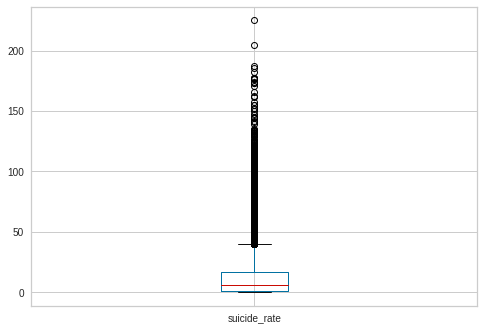

In [ ]:
df.suicide_rate.plot.box()

Interesting fact: The average suicide rate(suicides/100k_pop) is at 12.8, 50th percentile is 6 and 75th percential is 16.6. In country Aruba in 1995, the suicide rate for male who are 75+ years is 225. Looking further, that’s because there are only 889 people fall into this bucket and that year there were 2 people committed suicide. Another outlier is 2006 in Seychelles, the suicide rate for male who are 75+ years old is 205. Also noticing super small sample size: there are only 2 people committed suicide in this category. 



**Draw a chart to find correlation between age and suicide rate**

In [ ]:
age_bucket = [ '5-14 years', '15-24 years', '25-34 years', '35-54 years', '55-74 years', '75+ years']

suicide_by_age = (df
          .groupby(['age'])
          .agg({'population':'sum','suicides_no':'sum'})
          .reindex(age_bucket))

suicide_by_age['suicide_rate'] = suicide_by_age.suicides_no/suicide_by_age.population*100
suicide_by_age


,population,suicides_no,suicide_rate
age,,,
5-14 years,8398693237,52264,0.000622
15-24 years,8642633996,808521,0.009355
25-34 years,8438103587,1123912,0.013319
35-54 years,14375888123,2452141,0.017057
55-74 years,8803245340,1658443,0.018839
75+ years,2663281253,653118,0.024523


In [ ]:
x = suicide_by_age.index
y = suicide_by_age.suicide_rate

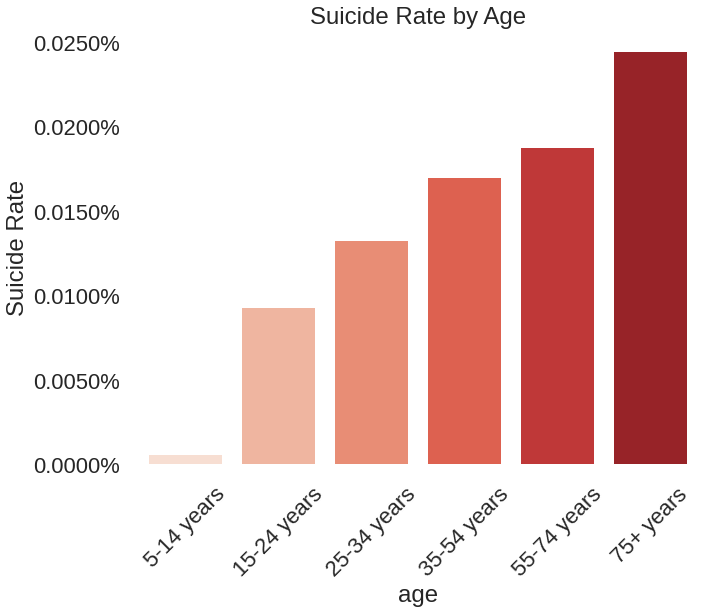

In [ ]:

with sns.color_palette('Reds'):
  with sns.plotting_context('poster'):
    with sns.axes_style('dark', {'axes.facecolor':'white'}):
      fig, ax = plt.subplots(figsize=(10, 8))
      sns.barplot(x, y, ax=ax)
      ax.tick_params(axis='x', labelrotation=45)
      ax.yaxis.set_major_formatter(ticker.PercentFormatter())
      ax.set_title("Suicide Rate by Age")
      ax.set(ylabel = 'Suicide Rate')

This chart shows the suicide rate by age bucket. Suicide rate is higher in the older bucket and the highest in 75+ age bucket. This is suprising to me because I thought the highest suicide rate happens in the mid-age group(35-54).Also I am suprised to see that there are 52,264 5-14 years old people committed suicide. 

**Draw a chart to find suicide rate time series** 

In [ ]:
suicide_by_year = (df
          .groupby(['year'])
          .agg({'population':'sum','suicides_no':'sum'})
          )

suicide_by_year['suicide_rate'] = suicide_by_year.suicides_no/suicide_by_year.population*100

x = suicide_by_year.index
y = suicide_by_year.suicide_rate


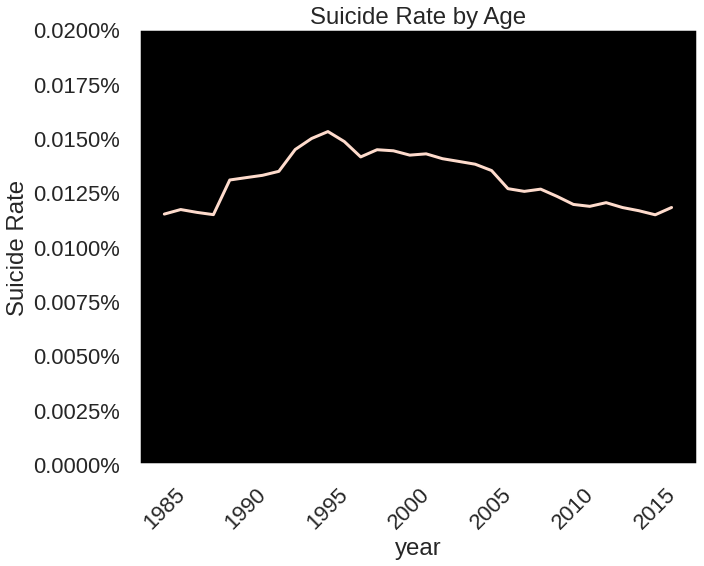

In [ ]:
with sns.color_palette('Reds'):
  with sns.plotting_context('poster'):
    with sns.axes_style('dark', {'axes.facecolor':'Black'}):
      fig, ax = plt.subplots(figsize=(10, 8))
      sns.lineplot(x, y, ax=ax)
      ax.tick_params(axis='x', labelrotation=45)
      ax.yaxis.set_major_formatter(ticker.PercentFormatter())
      ax.set_title("Suicide Rate by Age")
      ax.set(ylabel = 'Suicide Rate')
      ax.set(ylim=(0, 0.02))

This chart shows the time series of suicide rate. The highest suicide rate happens in 1995 and has declined since then. I don't have a hypothesis why 1995 has the highest suicide rate. If I have more time, I would like to explore other data sources such as unemployement rate or natural disaster data and find out the reason behind the high suicide rate. 

---



# Now try PCA model 

Step 1: Clean up the data

In [ ]:
df

,country,year,sex,age,suicides_no,population,suicide_rate,country_year,HDI_for_year,gdp_for_year,gdp_per_capita,generation
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,2156624900,796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,2156624900,796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,2156624900,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,2156624900,796,Boomers
5,Albania,1987,female,75+ years,1,35600,2.81,Albania1987,NaN,2156624900,796,G.I. Generation
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,63067077179,2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,63067077179,2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,63067077179,2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,63067077179,2309,Generation Z


1) Clean up Country: for simplity, I will only keep the top 5 countries and combine everything else into Other

In [ ]:
#find out the top countries

population_by_country = (df
          .groupby(['country'])
          .agg({'population':'sum'})
          )

population_by_country.sort_values(by='population', ascending=False)



,population
country,
United States,8054027201
Brazil,4856093548
Russian Federation,3690802620
Japan,3681024844
Mexico,2772959159
...,...
Cabo Verde,452179
Macau,346542
Saint Kitts and Nevis,117300


In [ ]:
def limit_countries(val):
        if val in  {'United States', 'Brazil', 'Russian Federation','Japan','Mexico'}:
            return val
        return 'Other'
df.country = df.country.apply(limit_countries)

2) clearn up age bucket

In [ ]:
df.age = df.age.replace({'5-14 years': '5'}).str.slice(0,2).astype(int).rename('age')

In [ ]:
df1 = df.filter(items=['country','year','sex','age','suicides_no', 'population','suicide_rate','gdp_for_year','gdp_per_capita'])

In [ ]:
df1

,country,year,sex,age,suicides_no,population,suicide_rate,gdp_for_year,gdp_per_capita
1,Other,1987,male,35,16,308000,5.19,2156624900,796
2,Other,1987,female,15,14,289700,4.83,2156624900,796
3,Other,1987,male,75,1,21800,4.59,2156624900,796
4,Other,1987,male,25,9,274300,3.28,2156624900,796
5,Other,1987,female,75,1,35600,2.81,2156624900,796
...,...,...,...,...,...,...,...,...,...
27815,Other,2014,female,35,107,3620833,2.96,63067077179,2309
27816,Other,2014,female,75,9,348465,2.58,63067077179,2309
27817,Other,2014,male,5,60,2762158,2.17,63067077179,2309
27818,Other,2014,female,5,44,2631600,1.67,63067077179,2309


Data cleaning is completed. Now convert categorical variables into dummy variables 

In [ ]:
 df2 = pd.get_dummies(df1)


In [ ]:
df2

,year,age,suicides_no,population,suicide_rate,gdp_for_year,gdp_per_capita,country_Brazil,country_Japan,country_Mexico,country_Other,country_Russian Federation,country_United States,sex_female,sex_male
1,1987,35,16,308000,5.19,2156624900,796,0,0,0,1,0,0,0,1
2,1987,15,14,289700,4.83,2156624900,796,0,0,0,1,0,0,1,0
3,1987,75,1,21800,4.59,2156624900,796,0,0,0,1,0,0,0,1
4,1987,25,9,274300,3.28,2156624900,796,0,0,0,1,0,0,0,1
5,1987,75,1,35600,2.81,2156624900,796,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27815,2014,35,107,3620833,2.96,63067077179,2309,0,0,0,1,0,0,1,0
27816,2014,75,9,348465,2.58,63067077179,2309,0,0,0,1,0,0,1,0
27817,2014,5,60,2762158,2.17,63067077179,2309,0,0,0,1,0,0,0,1
27818,2014,5,44,2631600,1.67,63067077179,2309,0,0,0,1,0,0,1,0


# PCA - Visualize High Dimension Data

In [ ]:
X = df2
std = preprocessing.StandardScaler()
X_std = pd.DataFrame(std.fit_transform(X), columns=X.columns)
X_std

,year,age,suicides_no,population,suicide_rate,gdp_for_year,gdp_per_capita,country_Brazil,country_Japan,country_Mexico,country_Other,country_Russian Federation,country_United States,sex_female,sex_male
0,-1.683731,-0.001480,-0.251187,-0.392878,-0.402201,-0.305062,-0.850890,-0.116419,-0.116419,-0.116419,0.263957,-0.108554,-0.116419,-1.000036,1.000036
1,-1.683731,-0.841929,-0.253404,-0.397556,-0.421186,-0.305062,-0.850890,-0.116419,-0.116419,-0.116419,0.263957,-0.108554,-0.116419,0.999964,-0.999964
2,-1.683731,1.679417,-0.267816,-0.466042,-0.433844,-0.305062,-0.850890,-0.116419,-0.116419,-0.116419,0.263957,-0.108554,-0.116419,-1.000036,1.000036
3,-1.683731,-0.421705,-0.258947,-0.401493,-0.502931,-0.305062,-0.850890,-0.116419,-0.116419,-0.116419,0.263957,-0.108554,-0.116419,-1.000036,1.000036
4,-1.683731,1.679417,-0.267816,-0.462514,-0.527718,-0.305062,-0.850890,-0.116419,-0.116419,-0.116419,0.263957,-0.108554,-0.116419,0.999964,-0.999964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27814,1.504508,-0.001480,-0.150305,0.454011,-0.519807,-0.263159,-0.770783,-0.116419,-0.116419,-0.116419,0.263957,-0.108554,-0.116419,0.999964,-0.999964
27815,1.504508,1.679417,-0.258947,-0.382534,-0.539848,-0.263159,-0.770783,-0.116419,-0.116419,-0.116419,0.263957,-0.108554,-0.116419,0.999964,-0.999964
27816,1.504508,-1.262154,-0.202409,0.234500,-0.561471,-0.263159,-0.770783,-0.116419,-0.116419,-0.116419,0.263957,-0.108554,-0.116419,-1.000036,1.000036
27817,1.504508,-1.262154,-0.220146,0.201124,-0.587840,-0.263159,-0.770783,-0.116419,-0.116419,-0.116419,0.263957,-0.108554,-0.116419,0.999964,-0.999964


In [ ]:
pca = decomposition.PCA()
pca_X = pd.DataFrame(pca.fit_transform(X_std), columns=[f'PC{i+1}' for i in range(len(X.columns))])
pca_X

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,-0.692312,1.168839,-0.948575,-0.828170,1.238478,0.084979,-0.554451,-0.272511,0.363393,-0.739333,0.348012,0.029305,0.112035,3.805883e-16,-2.203479e-15
1,-0.889481,-1.383616,-1.145767,-0.153917,1.271073,0.410698,-0.696319,-0.336104,0.506743,0.349960,-0.200946,0.159017,0.164229,1.222019e-16,-1.726606e-15
2,-0.732203,1.374397,-0.966673,0.074149,1.352883,-0.895542,-0.187004,-0.150627,0.233192,-1.502021,0.843811,-0.033832,0.082631,9.991339e-15,-7.748795e-16
3,-0.707906,1.070906,-0.938092,-1.098277,1.202958,0.345749,-0.654396,-0.302821,0.388811,-0.616978,0.269148,0.069694,0.130188,1.288982e-14,-4.999153e-15
4,-0.929056,-1.103199,-1.174624,1.174734,1.441993,-1.043468,-0.143879,-0.153797,0.303911,-0.816759,0.589304,0.039947,0.106483,-2.218268e-15,-4.887403e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27814,-0.373465,-1.456377,0.133420,0.356231,-0.495921,0.230864,0.490857,0.241437,-1.494452,0.328029,0.094328,-0.355805,-0.284931,9.879558e-17,1.661293e-16
27815,-0.804463,-1.194625,0.168357,1.306242,-0.420254,-0.823714,0.779171,0.369899,-1.581516,-0.565185,0.379032,0.113670,-0.050297,1.953726e-17,-1.316123e-16
27816,-0.310131,0.811656,0.381412,-1.478654,-0.692927,1.110408,0.137176,0.155604,-1.464469,0.065707,-0.030916,-0.191798,-0.192844,7.532893e-17,7.877698e-17
27817,-0.525556,-1.636020,0.175013,-0.352558,-0.602307,0.942940,0.180749,0.152975,-1.385654,0.776597,-0.339377,-0.103011,-0.159148,6.684470e-17,6.982112e-17


In [ ]:
pca.explained_variance_ratio_

array([2.43710121e-01, 1.54228199e-01, 1.04091474e-01, 8.68677591e-02,
       7.78941661e-02, 7.34333632e-02, 6.87430612e-02, 6.76522891e-02,
       4.05447895e-02, 3.52425912e-02, 2.78886338e-02, 1.23334244e-02,
       7.37012800e-03, 4.33795567e-33, 1.28951997e-33])

principle component 1 represents 24% of the information of the data. The first 3 principle components can only explain 40% of information from data


In [ ]:
#First component is 0.018*year + -0.0018*age + 0.37*suicide_no .....etc. 
pca.components_[0]

array([ 0.0184185 ,  0.00182123,  0.3705665 ,  0.46886401,  0.07856653,
        0.43223672,  0.09892634,  0.13987401,  0.20474965,  0.10022963,
       -0.45126189,  0.17838215,  0.35799401, -0.04778288,  0.04778288])

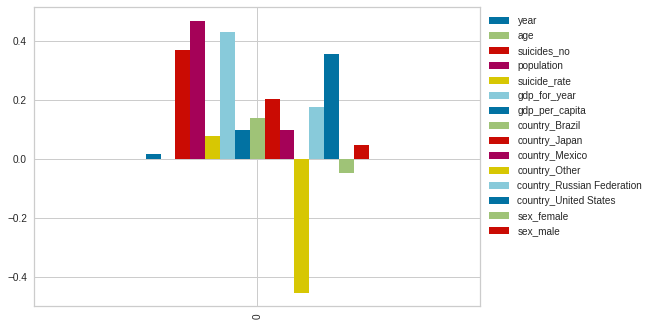

In [ ]:
# What columns make up the components 1?
(pd.DataFrame(pca.components_, columns=X.columns)
 .iloc[:1]
 .plot.bar()
 .legend(bbox_to_anchor=(1,1)))

Population, gdp_for_year, year and suicide_rate make up principal component 1. This does not surprise me because I expect that GDP and population should represent the most amount of information from the data. Also I have seen that suicide rate differs from year to year so it’s not surprising to see year pops up in principal component 1.  


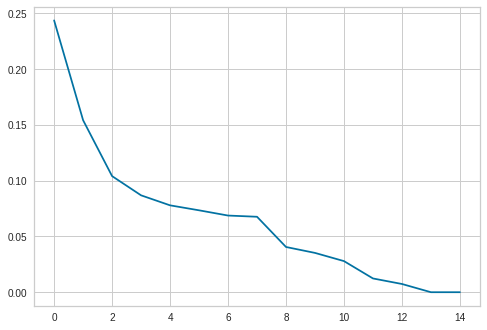

In [ ]:
plt.plot(pca.explained_variance_ratio_)

The first 10 principle component will represent 98% of the information.  

#Clustering 

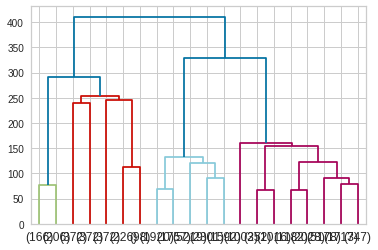

In [ ]:
dend = hierarchy.dendrogram(hierarchy.linkage(X_std, method='ward'),
                    truncate_mode='lastp', p=20)

Going to choose 4 clusters 

In [ ]:
agg = cluster.AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage = 'ward')
agg.fit(X_std)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=4)

In [ ]:
agg.labels_

array([1, 2, 1, ..., 1, 2, 2])

In [ ]:
(df2
 .assign(label=agg.labels_)
 .groupby('label')
 .agg(['mean','std'])
 .T)

label                                       0  ...             3
year                       mean  2.000450e+03  ...  2.000000e+03
                           std   8.740741e+00  ...  8.956318e+00
age                        mean  3.500000e+01  ...  3.500000e+01
                           std   2.381303e+01  ...  2.383682e+01
suicides_no                mean  1.634997e+03  ...  2.779605e+03
                           std   2.816542e+03  ...  2.752716e+03
population                 mean  1.041728e+07  ...  2.165061e+07
                           std   5.693951e+06  ...  9.448630e+06
suicide_rate               mean  1.615019e+01  ...  1.381981e+01
                           std   2.211244e+01  ...  1.322987e+01
gdp_for_year               mean  1.759846e+12  ...  1.051071e+13
                           std   1.706729e+12  ...  4.204691e+12
gdp_per_capita             mean  1.428717e+04  ...  3.926961e+04
                           std   1.418825e+04  ...  1.233412e+04
country_Brazil             mean  2.583333e-01  ...  0.000000e+00
                           std   4.378703e-01  ...  0.000000e+00
country_Japan              mean  2.583333e-01  ...  0.000000e+00
                           std   4.378703e-01  ...  0.000000e+00
country_Mexico             mean  2.583333e-01  ...  0.000000e+00
                           std   4.378703e-01  ...  0.000000e+00
country_Other              mean  0.000000e+00  ...  0.000000e+00
                           std   0.000000e+00  ...  0.000000e+00
country_Russian Federation mean  2.250000e-01  ...  0.000000e+00
                           std   4.177274e-01  ...  0.000000e+00
country_United States      mean  0.000000e+00  ...  1.000000e+00
                           std   0.000000e+00  ...  0.000000e+00
sex_female                 mean  5.000000e-01  ...  5.000000e-01
                           std   5.001737e-01  ...  5.006734e-01
sex_male                   mean  5.000000e-01  ...  5.000000e-01
                           std   5.001737e-01  ...  5.006734e-01

[30 rows x 4 columns]

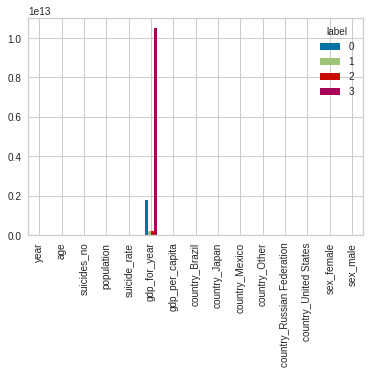

In [ ]:
(df2
 .assign(label=agg.labels_)
 .groupby('label')
 .mean()
 .T
 .plot.bar()
 )

The four clusters are pretty much purely separated by gdp for the year. That aligns with my hypothesis: suicide rate is highly determined by gdp for the year. 